In [1]:
# Import libraries
import pandas as pd
import nltk
import re
import string
from nltk import FreqDist
%pylab inline

# Import csv as pandas object
data_df = pd.read_csv('nepal.csv',encoding="ISO-8859-1")

# Print column headers
print(data_df.columns)

Populating the interactive namespace from numpy and matplotlib


Index(['TweetId', 'Date', 'Verified', 'Tweet URL', 'Tweet Hyperlink', 'Tweet',
       'HashTag', 'Screen Name', 'User Name', 'Media URL', 'Media Type',
       'Mentioned URL', 'Latitude', 'Longitude', 'User Create Date',
       'Number of Followers', 'Retweet'],
      dtype='object')


In [2]:
## In this cell, all the tweets are cleaned up for processing

# Define a function to remove all symbol characters and replace with a space 
def remove_symbol(str):
    for char in string.punctuation:
        str=str.replace(char,' ')
    return str

# Define a function to remove all symbol characters without replacement
def remove_symbol_nospace(str):
    for char in string.punctuation:
        str=str.replace(char,'')
    return str

# Store all the tweet data as a list object
dictpd=data_df.Tweet
dictlist=[tweet for tweet in dictpd]

# Initialize a variable to store the cleaned tweets
cleaned_dict=[] 

# Run a loop to clean the tweet to make it suitable for running analysis
for line in dictlist:
    line=line.lower() #lower case
    line=remove_symbol(line) #remove symbols and replace by space
    cleaned_dict.append(line) #add to initialized variable

In [3]:
## From all the tweet data, create a dictionary of tokens with alphabetic content only

#Initialize
tweettokens=[] #dictionary of all alphabetical tokens in the tweets
nestedtweet=[] #list of alphabetical tokens in a tweet-> list of tweets -> nestedtweet

#Loop which 1) splits tweets into tokens 2)checks for alphabetic only content 3)inserts into lists
for line in cleaned_dict:
    linelist=line.split(' ') #Split tweet into words
    templine=[] 
    for word in linelist:
        if word.isalpha(): #Add only alphabetical tokens to dictionary
            tweettokens.append(word) #append token to global dict
            templine.append(word) #append token to a list
    nestedtweet.append(templine) #append list of tokens in a tweet to a list 
    

#Create a set of all tokens which merges duplicates
tweettokendict=set(tweettokens)

#The number of all alphabetical tokens in all the tweets
print("The total number of alphabet-only tokens in all tweets:",len(tweettokens))
#The number of all unique alphabetical tokens in all the tweets
print("The total number of unique alphabet only tokens in all tweets:",len(tweettokendict))

print("The number of tweets analyzed:",len(nestedtweet))

The total number of alphabet-only tokens in all tweets: 3360432
The total number of unique alphabet only tokens in all tweets: 122451
The number of tweets analyzed: 212744


In [4]:
## Create a dictionary of location based tokens from NP_L4.csv
places_pd=pd.read_csv('NP_L4.csv')
places_pd.L2=places_pd.L2.str.lower() #L2 refers to administrative zone level location 
places_pd.L3=places_pd.L3.str.lower() #L3 refers to district level location

L2tokens=set(places_pd.L2) # dict of all L2 tokens
L3tokens=set(places_pd.L3) # dict of all L3 tokens
L3tokens.remove('kathmandu') # kathmandu gives too many false positives

# L4 items are cities/towns and the data has some formatting issues to be dealt with in this loop
for i in range(len(places_pd.L4)):
    item=places_pd.L4[i]
    item=remove_symbol_nospace(item)
    splititems=re.findall('[A-Z][^A-Z]*',item) #Create items seperated by capital letters: AbraKadabra - > [Abra] [Kadabra]
    item=' '.join(word for word in splititems if len(word)>2) # join them back if individual items are long enough
    places_pd.L4[i]=item.lower() #lower case
    
L4tokens=set(places_pd.L4) #list of L4 tokens
L4tokens=set(places for places in L4tokens if len(places)>4) #removal of short words from the set
L4tokens.remove('kathmandu') #removed kathmandu
L4tokens.remove('media') #removed media

print(len(L2tokens),"adminstrative zone level names,",len(L3tokens),"district level names and",len(L4tokens),
      "city/town level names were extracted from the location file ")

14 adminstrative zone level names, 74 district level names and 3512 city/town level names were extracted from the location file 


In [5]:
## Find out how many L4tokens exist in the tweets 

places_common=sorted(L4tokens.intersection(tweettokendict)) #taken an intersection of tweet dict with L4 dict

print(len(places_common),"unique town/city tokens were identified in the tweets")

340 unique town/city tokens were identified in the tweets


In [6]:
## Identify tweets with location based content

# Initialize
L2flag=[] #boolean for presence of a L2 token in a tweet
L3flag=[] 
L4flag=[]

placecounter=[] # aggregrate any L2,L3,L4 tokens present in this variable

# initialize
L3list=[None]*len(nestedtweet) # variable for storing the L3 token identified
L4list=[None]*len(nestedtweet) # variable for storing the L4 token identified

i=0
# loop to iterate through the tweets and identify location based tokens
for tweet in nestedtweet:
    L2boolean=len(set(tweet).intersection(L2tokens))!=0 # only found <200 tweetws
    L3boolean=len(set(tweet).intersection(L3tokens))!=0
    L4boolean=len(set(tweet).intersection(L4tokens))!=0
    if L3boolean: 
        place_=set(tweet).intersection(L3tokens)
        L3list[i]=place_
        for item in place_:
            placecounter.append(item)
    L3flag.append(L3boolean)
    if L4boolean: 
        place_=set(tweet).intersection(L4tokens)
        L4list[i]=place_
        for item in place_:
            placecounter.append(item)
    L4flag.append(L4boolean)
    i=i+1

Lallflag=[x or y for x,y in zip(L3flag,L4flag)] #boolean for presence of L3 or L4 token
print(sum(Lallflag),"tweets had location related content")

30384 tweets had location related content


In [7]:
placedistr=FreqDist(placecounter)
print("List of 20 most common location-related tokens and their frequency:")
placedistr.most_common(20)

List of 20 most common location-related tokens and their frequency:


[('bhaktapur', 14942),
 ('gorkha', 7546),
 ('basantapur', 3289),
 ('lamjung', 2022),
 ('lalitpur', 1956),
 ('nuwakot', 1648),
 ('those', 1222),
 ('patan', 1163),
 ('pokhara', 974),
 ('khudi', 861),
 ('orang', 777),
 ('sankhu', 768),
 ('bharatpur', 647),
 ('kirtipur', 573),
 ('dhading', 473),
 ('kumari', 251),
 ('change', 211),
 ('rasuwa', 203),
 ('langtang', 178),
 ('hetauda', 176)]

In [8]:
## Extract location based information from lat, long data

from shapely.geometry import Polygon
from shapely.geometry import Point

polyobject=[None]*len(places_pd) # initialize a variable for storing coordinate data as a shapely polygon object

#Construct a list of polygons from existing Lat Long data
for i in range(len(places_pd)):
    str=places_pd.WKT[i]
    m = str.split('((', 1)[1].split('))')[0]
    m = m.split(',')
    m = [list(map(float,item.split(' '))) for item in m]
    polyobject[i]=Polygon(m) #define the list of points as a polygon

# define a function to search the lat,long data through the polyobject and return the index 
def pointinNepal(xy_point):
    index=[]
    for k in range(len(polyobject)):
        if polyobject[k].contains(xy_point): #is the point inside the polygon?
            index.append(k)
    return index


kathmandu=Point(85.324,27.7172) #long, lat for nepal

posindex=[None]*len(data_df) #initalize a variable that will store the index of the location
L3GPS=[None]*len(data_df)
L4GPS=[None]*len(data_df)

#iterate through the lat long points in the tweet data  
for i in range(len(data_df)):
    if data_df.Latitude.notnull()[i]: #does tweet has lat,long data?
        lat=data_df.Latitude[i]
        long=data_df.Longitude[i]
        xy_point=Point(long,lat) 
        
        if xy_point.distance(kathmandu)<9: #search only those coordinates close enough to Nepal
            posindex[i]=pointinNepal(xy_point)
            temp=posindex[i]
            if temp: #if they found a match in the location database
                L3GPS[i]=places_pd.L3[temp[0]]
                L4GPS[i]=places_pd.L4[temp[0]]

Total number of tweets identified to be from Nepal: 994
Tweets could be traced out to 140 unique L4 tokens

List of 10 most commonly identified L4 tokens from LatLong data and their frequency:


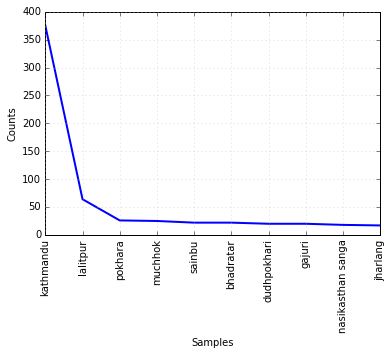

List of 10 most commonly identified L3 tokens from LatLong data and their frequency:


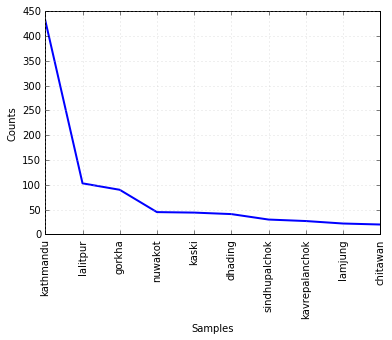

Tweets could be traced out to 34 out of 74 possible L3 tokens


In [9]:
#generate list for which lat long data belonged to Nepal
in_nepal=[i for i, x in enumerate(posindex) if x]

print("Total number of tweets identified to be from Nepal:",len(in_nepal))

#initialize
L4_GPS_freq=[]
L3_GPS_freq=[]

#fill up L3 and L4 tokens using index
for i in in_nepal:
    L4_GPS_freq.append(places_pd.L4[posindex[i][0]])
    L3_GPS_freq.append(places_pd.L3[posindex[i][0]])

L4_GPS_freqdist=FreqDist(L4_GPS_freq)
L3_GPS_freqdist=FreqDist(L3_GPS_freq)

print("Tweets could be traced out to",len(set(L4GPS)),"unique L4 tokens")
print("""
List of 10 most commonly identified L4 tokens from LatLong data and their frequency:""")
L4_GPS_freqdist.plot(10)

print("List of 10 most commonly identified L3 tokens from LatLong data and their frequency:")
L3_GPS_freqdist.plot(10)
print("Tweets could be traced out to",len(set(L3GPS)),"out of",len(L3tokens),"possible L3 tokens")

In [10]:
#Add analyzed data to the original data and save to a csv file

data_df["L3 token from Tweet"]=L3list
data_df["L4 token from Tweet"]=L4list
data_df["L3 token from LatLong"]=L3GPS
data_df["L4 token from LatLong"]=L4GPS
data_df.to_csv('nepal_tweets_loc.csv')